In [51]:
import numpy as np
import astropy.units as u
from astropy.io import fits

import time
import os
from pathlib import Path

import poppy

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
platform = jax.devices()[0].platform
device = jax.devices()[0].device_kind

print(f'Jax platform: {platform}')
print(f'Jax device: {device}')

import utils
import imshows
from imshows import *

wavelength = 633*u.nm
pupil_diam = 10*u.mm
fl = 150*u.mm
fnum = fl.to_value(u.mm)/pupil_diam.to_value(u.mm)

# bw = 0.1
# nwaves = 5
# wavelengths = jnp.linspace(wavelength-wavelength*bw/2.0, wavelength+wavelength*bw/2.0, num=nwaves)
# spectrum = jnp.linspace(1, 2, num=nwaves)

npix = 512

um_per_lamD = wavelength.to(u.um) * fnum
pixelscale_m = 3.45e-6
pixelscale_lamD = pixelscale_m / um_per_lamD.to_value(u.m)
print(pixelscale_m, pixelscale_lamD)

def pad_or_crop( arr_in, npix ):
    n_arr_in = arr_in.shape[0]
    if n_arr_in == npix:
        return arr_in
    elif npix < n_arr_in:
        x1 = n_arr_in // 2 - npix // 2
        x2 = x1 + npix
        arr_out = arr_in[x1:x2,x1:x2]
    else:
        arr_out = jnp.zeros((npix,npix), dtype=arr_in.dtype)
        x1 = npix // 2 - n_arr_in // 2
        x2 = x1 + n_arr_in
        arr_out = arr_out.at[x1:x2,x1:x2].set(arr_in)
    return arr_out

def sum_ims(ims, exp_times, sat_thresh=100, nbits=12, plot=False):
    mono_flux_ims = self.calc_images(quiet=quiet)
    bb_flux_im = self.R_throughput * xp.sum(mono_flux_ims, axis=0) # assuimng source flux pre-implemented
    if plot: imshows.imshow1(bb_flux_im, 'Total image flux [ph/s/pix]', lognorm=True)

    # ims = []
    # im_masks = []
    total_flux = 0.0
    pixel_weights = 0.0
    for i in range(len(exp_times)):
        frame = ims[0]
        pixel_sat_mask = averaged_frame > (2**nbits - sat_thresh)

        if self.subtract_bias:
            averaged_frame -= self.EMCCD.bias
        
        pixel_weights += ~pixel_sat_mask
        flux_im = averaged_frame/self.exp_time/self.EMCCD.em_gain # normalize by the exposure time and gain for this frame
        flux_im[pixel_sat_mask] = 0 # mask out the saturated pixels

        if plot: 
            imshows.imshow3(pixel_sat_mask, averaged_frame, flux_im, 
                            'Pixel Saturation Mask', 
                            f'Averaged EMCCD Frame:\nExposure Time = {self.exp_times_list[i]}s\nGain = {self.EMCCD.em_gain:.1f}\nN-frames = {self.Nframes:d}', 
                            'Masked Flux Image', 
                            lognorm2=True, lognorm3=True)
            
        total_flux += flux_im
        
    total_flux_im = total_flux/pixel_weights

    return total_flux_im/self.Imax_ref

Jax platform: gpu
Jax device: NVIDIA A100 80GB PCIe
3.45e-06 0.36334913112164297


In [5]:
wf = poppy.FresnelWavefront(beam_radius=pupil_diam/2, npix=npix, oversample=1)
ap = poppy.NgonAperture(nsides=16, radius=pupil_diam/2).get_transmission(wf)

Oversampling > 2x suggested for reliable results in Fresnel propagation.


In [6]:
utils.save_fits(f'aperture_16_{npix:d}.fits', ap.get())

Saved data to:  aperture_16_512.fits


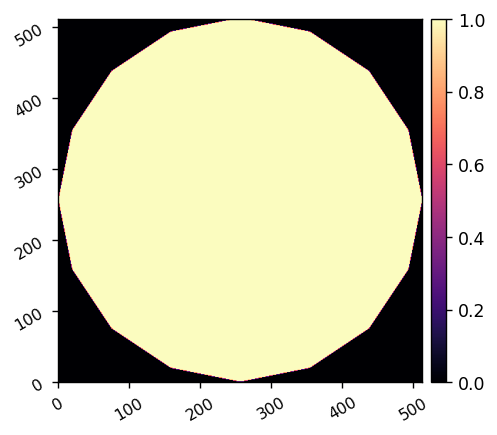

In [13]:
ap = jnp.asarray(fits.getdata(f'aperture_16_{npix:d}.fits'))
imshow1(ap)

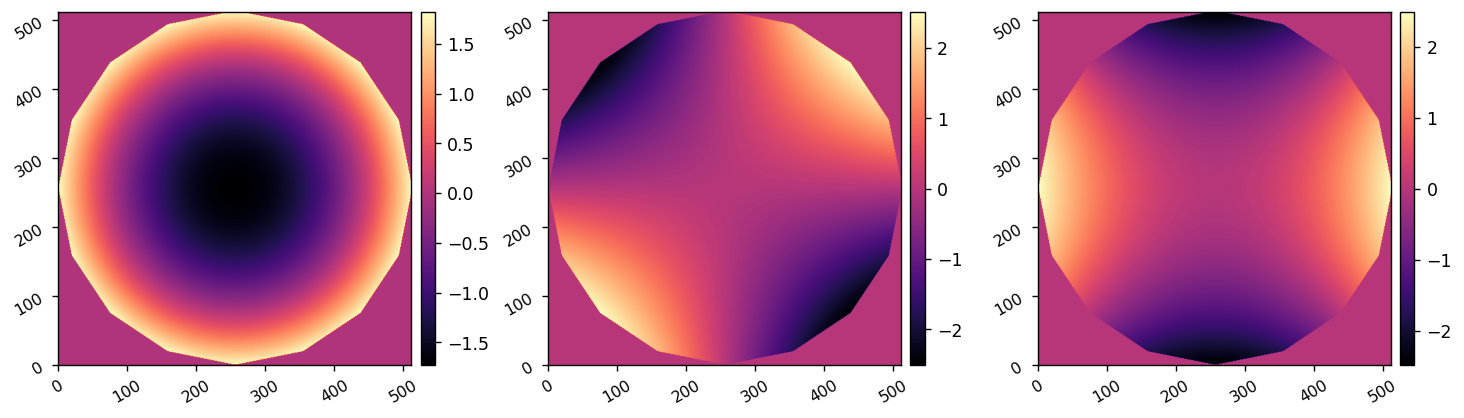

In [52]:
nmodes = 25
zmodes = poppy.zernike.arbitrary_basis(ap, nterms=nmodes+3, outside=0)[3:]
modes = zmodes.reshape(nmodes, npix**2).T
imshow3(zmodes[0], zmodes[1], zmodes[2])

# Initialize the model and do the estimation

In [53]:
import estimation
import model

wavelengths = jnp.array([wavelength.to_value(u.m)])
spectrum = jnp.linspace(1, 1, num=1)

In [54]:
long_defocus = np.array([-4e-3, -2e-3, 1e-3, 3e-3])
print(long_defocus)

nim = 128

mod = model.ForwardModel(npix, nim, fnum, pixelscale_m, 
                           wavelength.to_value(u.m), wavelengths, 
                           long_defocus, 
                        #    spectrum=spectrum, 
                           )


[-0.004 -0.002  0.001  0.003]


In [14]:
0.26*550e-9

1.4300000000000002e-07

In [55]:
0.017 * wavelength.to_value(u.m)

1.0761000000000001e-08

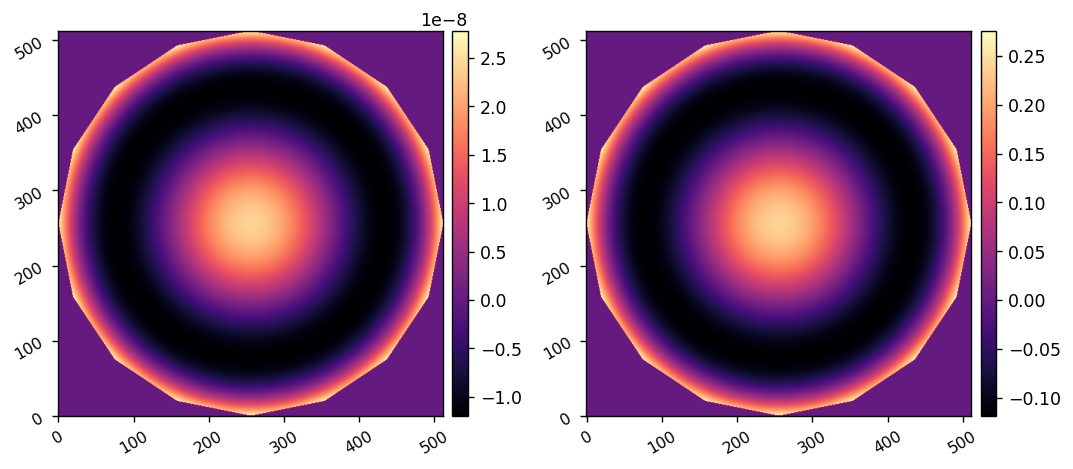

In [56]:
np.random.seed(123)
a = 5e-9 * np.random.randn(nmodes)
a[0] = 0 # just set the defocus coefficient to 0

a = np.zeros(nmodes)
# a[3] = 10e-9
# a[7] = 25e-9
a[7] = 0.017 * wavelength.to_value(u.m)

wfe = modes.get().dot(a).reshape(npix,npix)
pupil = ap*jnp.exp(1j*2*np.pi*wfe/wavelength.to_value(u.m))
imshow2(wfe, np.asarray(jnp.angle(pupil)))

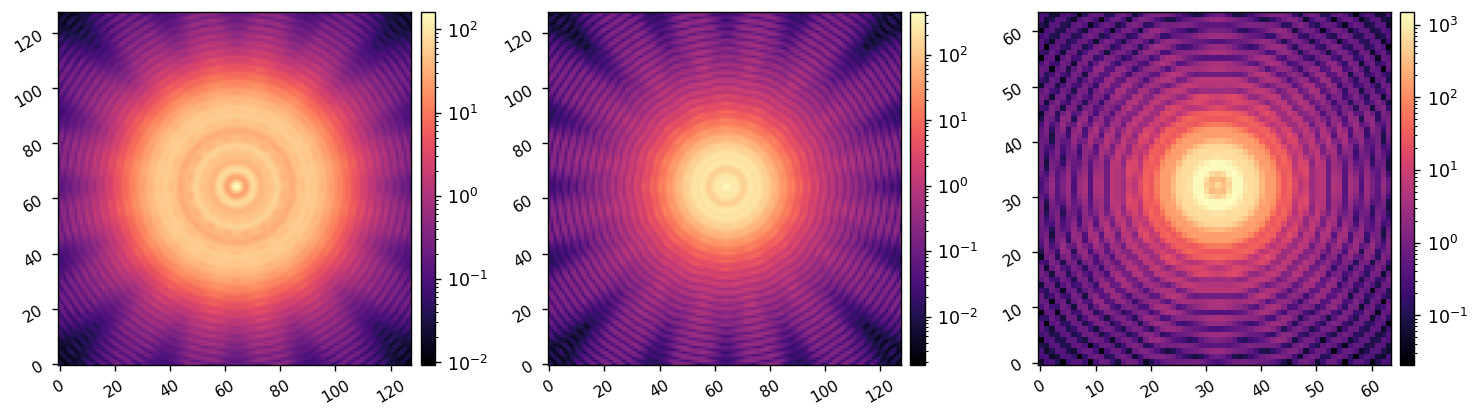

In [58]:
psfs = model.forward_propagate(ap, wfe, mod.wavelengths, mod.fresnel_TFs, mod.Mx, mod.My)
imshow3(psfs[0], psfs[1], psfs[2], lognorm=True, npix3=64)

In [44]:
type(jnp.asarray(zmodes.get()))

jaxlib.xla_extension.Array

In [46]:
# estimator = estimation.Estimation(mod, estimate_phase=True, maxiter=1000, wreg=1e-10)
# estimator = estimation.Estimation(mod, estimate_phase=True, estimate_amplitude=True, maxiter=100, wreg=1e-2)

estimator = estimation.Estimation(mod, estimate_phase=True, maxiter=100, wreg=1e-5,
                                  phase_modal=True, 
                                  modes=jnp.asarray(zmodes.get()))

In [47]:
fit, err, objvals = estimator.run(psfs, ap)

INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.9972774216960342 Stepsize:1.0  Decrease Error:0.9972774216960342  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 2 Minimum Decrease & Curvature Errors (stop. crit.): 0.997633123242706 Stepsize:0.4999999999795621  Decrease Error:0.997633123242706  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 3 Minimum Decrease & Curvature Errors (stop. crit.): 0.9958267199489433 Stepsize:0.2113248653729397  Decrease Error:0.9958267199489433  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 4 Minimum Decrease & Curvature Errors (stop. crit.): 0.9945898603908536 Stepsize:0.09219614415228913  Decrease Error:0.9945898603908536  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 5 Minimum Decrease & Curvature Errors (stop. crit.): 0.9975789595057247 Stepsize:0.04000451458093492  Decrease Error:0.9975789595057247  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 6 Minimum Decrease &

2024-04-30 13:20:50.058246: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none


INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 1.110218583733058e-16 Stepsize:0.2109375  Decrease Error:1.110218583733058e-16  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 2 Minimum Decrease & Curvature Errors (stop. crit.): 1.4671827285795203e-25 Stepsize:0.10546875  Decrease Error:0.0  Curvature Error:1.4671827285795203e-25 
INFO: jaxopt.ZoomLineSearch: Iter: 3 Minimum Decrease & Curvature Errors (stop. crit.): 4.718085579671868e-23 Stepsize:0.07031240565328814  Decrease Error:0.0  Curvature Error:4.718085579671868e-23 
INFO: jaxopt.ZoomLineSearch: Iter: 4 Minimum Decrease & Curvature Errors (stop. crit.): 1.0433803984774743e-22 Stepsize:0.02758882631782669  Decrease Error:0.0  Curvature Error:1.0433803984774743e-22 
INFO: jaxopt.ZoomLineSearch: Iter: 5 Minimum Decrease & Curvature Errors (stop. crit.): 1.110218583733058e-16 Stepsize:0.012180162454528038  Decrease Error:1.110218583733058e-16  Curvature Error:1.2495270335022954e-22 


Text(0, 0.5, 'objective function value')

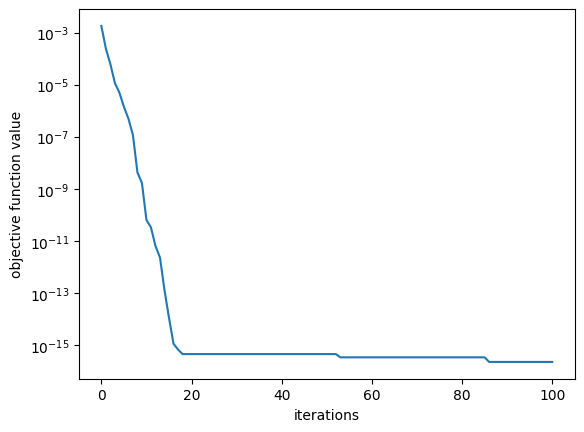

In [48]:
plt.semilogy(objvals)
plt.xlabel('iterations')
plt.ylabel('objective function value')

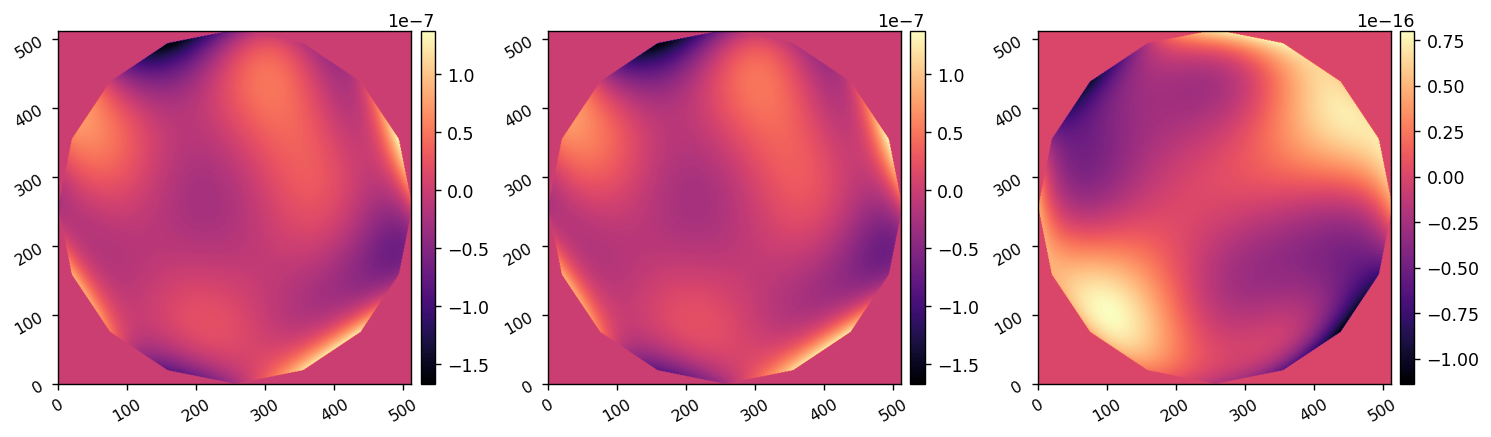

In [49]:
opd_est = modes.get().dot(fit[-1]).reshape(npix,npix)
est_wfe = ap*(opd_est)
diff = est_wfe-wfe
imshow3(est_wfe, wfe, diff, vmin1=jnp.min(wfe), vmax1=jnp.max(wfe))